## 'https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/'

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt



[nltk_data] Downloading package stopwords to C:\Users\Mrinmoy
[nltk_data]     Sadhukhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Mrinmoy Sadhukhan\anaconda3\envs\nltk_pipeline\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11314 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   content       11314 non-null  object
 1   target        11314 non-null  int64 
 2   target_names  11314 non-null  object
dtypes: int64(1), object(2)
memory usage: 353.6+ KB


In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [8]:
 #Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [12]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-03-11 07:33:13.409904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-03-11 07:33:13.410297: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1)

[['thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [41]:
print(data_lemmatized[:3])

[['thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['final', 'call', 'summary', 'final', 'call', 'si', 'clock', 'report', 'keyword', 'si', 'acceleration', 'clock', 'upgrade', 'article', 'line', 'nntp_poste', 'host', 'fair', 'number', 'brave', 'soul', 'upgrade', 'si', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'cpu', 'rate', 'speed', 'add', 'card', 'adapter', 'heat_sink', 'hour', 'usage', 'day', 'floppy_disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'next', 'day', 'add', 'network', '

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized) ### from here rochhio expansion system will entry !! may be

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [40]:
print((id2word))

Dictionary(51882 unique tokens: ['addition', 'body', 'bring', 'call', 'car']...)


In [16]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)],
 [('call', 2),
  ('day', 2),
  ('host', 1),
  ('line', 1),
  ('nntp_poste', 1),
  ('thank', 1),
  ('acceleration', 1),
  ('adapter', 1),
  ('add', 2),
  ('answer', 1),
  ('article', 1),
  ('attain', 1),
  ('base', 1),
  ('brave', 1),
  ('brief', 1),
  ('card', 1),
  ('clock', 4),
  ('cpu', 1),
  ('detail', 1),
  ('do', 1

In [17]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 5),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(3, 2),
  (5, 2),
  (13, 1),
  (18, 1),
  (25, 1),
  (37, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 4),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 3),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 3),
  (85, 1)]

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.705*"ax" + 0.026*"graphic" + 0.013*"peace" + 0.013*"bomb" + '
  '0.012*"convert" + 0.009*"homosexual" + 0.007*"violence" + 0.006*"capture" + '
  '0.006*"birth" + 0.005*"gif"'),
 (1,
  '0.028*"people" + 0.019*"say" + 0.013*"believe" + 0.013*"reason" + '
  '0.012*"point" + 0.011*"evidence" + 0.011*"mean" + 0.011*"many" + '
  '0.011*"make" + 0.010*"state"'),
 (2,
  '0.057*"trust" + 0.049*"stupid" + 0.043*"session" + 0.032*"registration" + '
  '0.028*"conference" + 0.026*"implementation" + 0.021*"speaker" + '
  '0.021*"beautiful" + 0.018*"fish" + 0.018*"custom"'),
 (3,
  '0.092*"mail" + 0.055*"price" + 0.049*"sale" + 0.040*"cpu" + 0.036*"pin" + '
  '0.033*"disk" + 0.030*"offer" + 0.029*"tape" + 0.022*"board" + 0.021*"bus"'),
 (4,
  '0.208*"window" + 0.068*"server" + 0.062*"package" + 0.044*"motif" + '
  '0.033*"mit" + 0.028*"crash" + 0.022*"application" + 0.014*"event" + '
  '0.013*"programmer" + 0.013*"honor"'),
 (5,
  '0.058*"system" + 0.046*"use" + 0.027*"bit" + 0.025*"compute

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.488097017718566

Coherence Score:  0.4915515915416987


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.326622 -0.134315       1        1  24.194709
1     -0.333230 -0.125238       2        1  21.308074
17    -0.285779 -0.060408       3        1  12.398329
12    -0.134071  0.078792       4        1   6.883852
5     -0.163754  0.054425       5        1   6.567389
11    -0.089425  0.385584       6        1   6.538882
0      0.061975  0.063352       7        1   4.526610
19     0.015068  0.118288       8        1   3.138600
10     0.007006 -0.035352       9        1   2.094716
7      0.057259 -0.007326      10        1   2.041601
3      0.065142 -0.025848      11        1   1.733341
18     0.038371 -0.020864      12        1   1.557142
15     0.067932 -0.000241      13        1   1.385791
13     0.067927 -0.009724      14        1   1.379869
9      0.098334  0.002385      15        1   1.221748
16     0.116846 -0.026389      16        1   1.187287
4      0.161400 -0.048302      17        1   0.728894
8      0.178896 -0.065642      18        1   0.490622
2      0.196701 -0.071235      19        1   0.334779
14     0.200023 -0.071943      20        1   0.287765, topic_info=               Term          Freq         Total Category  logprob  loglift
4435             ax  41584.000000  41584.000000  Default  30.0000  30.0000
18             line  16918.000000  16918.000000  Default  29.0000  29.0000
207           write  13232.000000  13232.000000  Default  28.0000  28.0000
143    organization  10186.000000  10186.000000  Default  27.0000  27.0000
45          article   9135.000000   9135.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1937            usa     73.728862    267.965521  Topic20  -3.9290   4.5603
5309           vram      0.040029      1.329120  Topic20 -11.4476   2.3481
14611    vram_simms      0.040028      1.329106  Topic20 -11.4476   2.3481
14337      protocol      0.040028      1.329133  Topic20 -11.4476   2.3481
7126        encrypt      0.040028      1.329183  Topic20 -11.4476   2.3480

[846 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3348     19  0.957439      abstract
1391      8  0.998464        accept
3181     13  0.987484  access_digex
1472     16  0.992803       acquire
1554      2  0.998858           act
...     ...       ...           ...
812       9  0.992548     yesterday
628       4  0.374606         young
628       8  0.476415         young
628       9  0.147493         young
2247     14  0.994821          zone

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 18, 13, 6, 12, 1, 20, 11, 8, 4, 19, 16, 14, 10, 17, 5, 9, 3, 15])

In [22]:
#import requests
#from tqdm import tqdm

In [23]:
#response=requests.get('http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip',stream=True)

In [24]:
#with open("mallet-2.0.8.zip", "wb") as handle:
#    for data in tqdm(response.iter_content()):
#        handle.write(data)

In [25]:
#import zipfile


In [26]:
#with zipfile.ZipFile("mallet-2.0.8.zip","r") as zip_ref:
#    zip_ref.extractall("mallet-2.0.8")

In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [28]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('make', 0.04059471003778545),
   ('thing', 0.03722687695087892),
   ('people', 0.033974043042549695),
   ('time', 0.03394118613438475),
   ('ve', 0.029636931164777395),
   ('good', 0.027468375225891243),
   ('problem', 0.02362411697059307),
   ('bad', 0.017562017414161326),
   ('lot', 0.015032035485460818),
   ('put', 0.013257762444553968)]),
 (15,
  [('image', 0.021165256298025483),
   ('software', 0.017760918198618813),
   ('mail', 0.01455111370489252),
   ('sale', 0.013364458710242194),
   ('graphic', 0.012703044450928899),
   ('line', 0.011555296177414649),
   ('include', 0.011224589047758),
   ('computer', 0.010991148720941544),
   ('format', 0.009765587005155141),
   ('fax', 0.009707226923451027)]),
 (6,
  [('drive', 0.031569808253592936),
   ('card', 0.021058853955000553),
   ('problem', 0.017585990320316252),
   ('driver', 0.015627886356079358),
   ('bit', 0.015073705988842502),
   ('system', 0.014796615805224074),
   ('scsi', 0.012986293272250342),
   ('monitor', 0.0

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


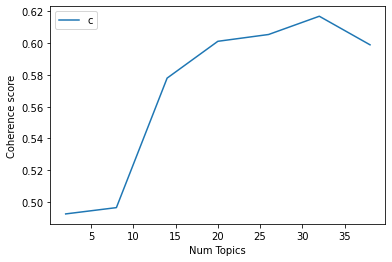

In [42]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4925
Num Topics = 8  has Coherence Value of 0.4964
Num Topics = 14  has Coherence Value of 0.578
Num Topics = 20  has Coherence Value of 0.6012
Num Topics = 26  has Coherence Value of 0.6055
Num Topics = 32  has Coherence Value of 0.617
Num Topics = 38  has Coherence Value of 0.599


In [33]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"people" + 0.014*"day" + 0.013*"leave" + 0.012*"happen" + '
  '0.011*"start" + 0.011*"time" + 0.009*"fire" + 0.008*"hear" + 0.008*"child" '
  '+ 0.008*"kill"'),
 (1,
  '0.011*"drug" + 0.011*"study" + 0.010*"problem" + 0.008*"food" + '
  '0.007*"effect" + 0.006*"research" + 0.006*"doctor" + 0.006*"patient" + '
  '0.006*"disease" + 0.006*"medical"'),
 (2,
  '0.044*"good" + 0.034*"make" + 0.033*"thing" + 0.026*"post" + 0.025*"ve" + '
  '0.023*"time" + 0.019*"read" + 0.019*"bad" + 0.017*"find" + 0.016*"people"'),
 (3,
  '0.016*"mail" + 0.015*"image" + 0.015*"information" + 0.015*"software" + '
  '0.015*"include" + 0.014*"file" + 0.014*"list" + 0.013*"send" + '
  '0.010*"address" + 0.009*"version"'),
 (4,
  '0.014*"christian" + 0.012*"people" + 0.010*"man" + 0.010*"word" + '
  '0.009*"church" + 0.009*"book" + 0.009*"life" + 0.008*"religion" + '
  '0.008*"love" + 0.007*"bible"'),
 (5,
  '0.029*"drive" + 0.022*"card" + 0.020*"problem" + 0.019*"system" + '
  '0.015*"driver" + 0.0

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.2179,"car, buy, sale, price, sell, bike, good, drive...",From: (wheres my thing) Subject: WHAT car is t...
1,1,5.0,0.1944,"drive, card, problem, system, driver, bit, scs...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,2.0,0.1528,"good, make, thing, post, ve, time, read, bad, ...",From: (Thomas E Willis) Subject: PB questions....
3,3,12.0,0.0874,"write, article, line, organization, university...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,15.0,0.1469,"window, run, file, set, program, display, prob...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,13.0,0.2966,"gun, file, line, number, entry, weapon, firear...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,1.0,0.1133,"drug, study, problem, food, effect, research, ...",From: (brian manning delaney) Subject: Brain T...
7,7,5.0,0.5192,"drive, card, problem, system, driver, bit, scs...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,15.0,0.1308,"window, run, file, set, program, display, prob...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,5.0,0.2447,"drive, card, problem, system, driver, bit, scs...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8286,"people, day, leave, happen, start, time, fire,...",From: (David Davidian) Subject: Accounts of An...
1,1.0,0.7022,"drug, study, problem, food, effect, research, ...",From: Subject: How To Prevent Kidney Stone For...
2,2.0,0.4263,"good, make, thing, post, ve, time, read, bad, ...","From: (Tom) Subject: Fred and Tom, ad naseum X..."
3,3.0,0.7804,"mail, image, information, software, include, f...",From: (Nick C. Fotis) Subject: (17 Apr 93) Com...
4,4.0,0.7334,"christian, people, man, word, church, book, li...",From: (Robert Weiss) Subject: [lds] Ricks repl...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"car, buy, sale, price, sell, bike, good, drive...",482.0,0.0426
1.0,5.0,"drive, card, problem, system, driver, bit, scs...",517.0,0.0457
2.0,2.0,"good, make, thing, post, ve, time, read, bad, ...",227.0,0.0201
3.0,12.0,"write, article, line, organization, university...",603.0,0.0533
4.0,15.0,"window, run, file, set, program, display, prob...",699.0,0.0618
...,...,...,...,...
11309.0,1.0,"drug, study, problem, food, effect, research, ...",NaN,NaN
11310.0,5.0,"drive, card, problem, system, driver, bit, scs...",NaN,NaN
11311.0,5.0,"drive, card, problem, system, driver, bit, scs...",NaN,NaN
11312.0,14.0,"space, launch, earth, system, satellite, resea...",NaN,NaN
